<a href="https://colab.research.google.com/github/bonnefco/P8/blob/main/P8_BERT_LARGE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import ast
from scipy import stats
import tensorflow
from sklearn.model_selection import train_test_split
import os
import glob

In [52]:
!pip install transformers
import transformers
from transformers import TFAutoModel, AutoConfig
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
tensorflow.keras.backend.clear_session()

# Fonctions

In [54]:
def plot_curves(history):

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

  return

# Importation du dataset

In [55]:
df_effective_args = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train.csv',encoding="utf-8",header=(0))

## Lier chaque discourse_id avec le texte integrale

In [56]:
def create_dict_key_id___value_essay_text(path_folder):

  list_texts_essay = glob.glob(path_folder + '/*')
  dictionnary = {}
  for text in list_texts_essay : 
      essay_text = open(text, 'r').read()
      id_essay = text.split('/')[-1].split('.')[0]
      dictionnary[id_essay] = essay_text

  return dictionnary

def df_link_essay_id_and_text_essay(df, path_folder) :
  dictionnary_key_id___value_essay_text = create_dict_key_id___value_essay_text(path_folder)
  df['essay_text'] = df['essay_id'].map(dictionnary_key_id___value_essay_text)
  return df

In [57]:
path_train_folder = '/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train'
df_effective_args = df_link_essay_id_and_text_essay(df_effective_args, path_train_folder)

# Nettoyage 

## Suppression incohérence du dataset

In [58]:
#doublons possèdent deux "discourse_effectiveness" différents
df_duplicates = df_effective_args[df_effective_args.duplicated(subset=['discourse_text'], keep=False)]
df_duplicates_different_discourse_effectiveness = df_duplicates[~df_duplicates.duplicated(subset=['discourse_text', 'discourse_effectiveness'], keep=False)]
list_index_to_drop = df_duplicates_different_discourse_effectiveness.index.values.tolist()

#doublons possèdent deux "discourse_type" différents
df_duplicates_different_discourse_type = df_duplicates[~df_duplicates.duplicated(subset=['discourse_text', 'discourse_type'], keep=False)]
list_index_to_drop += df_duplicates_different_discourse_type.index.values.tolist()
df_without_incoherence = df_effective_args.drop(list_index_to_drop, axis=0)

#Conservation d'un doublon sur deux
df_effective_args_without_duplicates = df_without_incoherence.drop_duplicates(subset=['discourse_text'], keep='first')

# Encoder

In [ ]:
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

# Configs

In [ ]:
Cfg = {
    # Model Configs
    "model_name": "microsoft/deberta-v3-large",
    "max_len": 512,
    
    # Train Configs
    "fold_num": 5,
    "lr": 5e-6,
    "batch_size": 8,
    "valid_batch_size": 32,
    "epochs": 1,
    
    # Path
    "path_input_csv": '/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train_light.csv',
    "path_output_save_h5_model" : '/content/drive/MyDrive/Colab_Notebooks/P8/models'
}

In [ ]:
Dictionnary_to_encode_effectivness = {"Ineffective": 0, "Adequate": 1, "Effective": 2}

# Init Tokenizer

In [ ]:
tokenizer_BERT = transformers.AutoTokenizer.from_pretrained(Cfg['model_name'], use_fast=True, max_length = Cfg['max_len'])
#tokenizer_BERT(pad_token = '[PAD]', truncation = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
AutoConfig.from_pretrained(Cfg['model_name'])

DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-large",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1024,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.21.1",
  "type_vocab_size": 0,
  "vocab_size": 128100
}

In [ ]:
def _prepare_training_data_helper(cfg, tokenizer, df, is_train):
    training_samples = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        idx = row["essay_id"]
        discourse_text = row["discourse_text"]
        discourse_type = row["discourse_type"]

        if is_train:
            filename = os.path.join(cfg.input, "train_light", idx + ".txt")
        else:
            filename = os.path.join(cfg.input, "test", idx + ".txt")

        with open(filename, "r") as f:
            text = f.read()

        encoded_text = tokenizer.encode_plus(
            discourse_type + " " + discourse_text,
            text,
            add_special_tokens=False,
        )
        input_ids = encoded_text["input_ids"]

        sample = {
            "discourse_id": row["discourse_id"],
            "input_ids": input_ids,
            # "discourse_text": discourse_text,
            # "essay_text": text,
            # "mask": encoded_text["attention_mask"],
        }

        if "token_type_ids" in encoded_text:
            sample["token_type_ids"] = encoded_text["token_type_ids"]

        label = row["discourse_effectiveness"]

        sample["label"] = LABEL_MAPPING[label]

        training_samples.append(sample)
    return training_samples


def prepare_training_data(df, tokenizer, cfg, num_jobs, is_train):
    training_samples = []

    df_splits = np.array_split(df, num_jobs)

    results = Parallel(n_jobs=num_jobs, backend="multiprocessing")(
        delayed(_prepare_training_data_helper)(cfg, tokenizer, df, is_train) for df in df_splits
    )
    for result in results:
        training_samples.extend(result)

    return training_samples

# Fonctions utiles

# Nettoyage

## Chargement fichier source

In [ ]:
df_effective_args = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train_light.csv',encoding="utf-8",header=(0))
df_effective_args

,discourse_text,discourse_type,discourse_effectiveness
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,"On my perspective, I think that the face is a ...",Position,Adequate
2,I think that the face is a natural landform be...,Claim,Adequate
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,People thought that the face was formed by ali...,Counterclaim,Adequate
...,...,...,...
36672,For many people they don't like only asking on...,Claim,Adequate
36673,also people have different views and opinions ...,Claim,Adequate
36674,Advice is something that can impact a persons ...,Position,Adequate
36675,someone can use everything that many people sa...,Evidence,Ineffective


## Encodage des labels

In [ ]:
df_effective_args["discourse_effectiveness_number"] = df_effective_args["discourse_effectiveness"].replace({"Ineffective": 0, "Adequate": 1, "Effective": 2})

credits : https://www.kaggle.com/code/iamleonie/feedback-prize-eda-starter-for-beginners

Get the sep_token from the tokenizer and create the input sequences from discourse_type and discourse_text.

sep_token - A special token separating two different sentences in the same input (see https://huggingface.co/docs/transformers/main_classes/tokenizer)

## Feature Engineering

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
sep = tokenizer_BERT.sep_token
df_effective_args['discourse_type_SEP_discourse_text'] = df_effective_args.discourse_type + sep + df_effective_args.discourse_text
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t..."
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...


## Tokenization

In [ ]:
df_effective_args['discourse_tokenized'] = df_effective_args['discourse_type_SEP_discourse_text'].apply(tokenizer_BERT.tokenize)

In [ ]:
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text,discourse_tokenized
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","[▁lead, [SEP], ▁hi, ,, ▁i, ', m, ▁is, a, ac, ,..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t...","[▁position, [SEP], ▁on, ▁my, ▁perspective, ,, ..."
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...,"[▁claim, [SEP], ▁i, ▁think, ▁that, ▁the, ▁face..."


## Longueur chaine de caractere

In [ ]:
def counter_len_in_text(string):
  return len(string)

In [ ]:
df_effective_args['Longueur_texte'] = df_effective_args['discourse_tokenized'].apply(counter_len_in_text)

In [ ]:
df_effective_args.head(3)

,discourse_text,discourse_type,discourse_effectiveness,discourse_effectiveness_number,discourse_type_SEP_discourse_text,discourse_tokenized,Longueur_texte
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","[▁lead, [SEP], ▁hi, ,, ▁i, ', m, ▁is, a, ac, ,...",88
1,"On my perspective, I think that the face is a ...",Position,Adequate,1,"Position[SEP]On my perspective, I think that t...","[▁position, [SEP], ▁on, ▁my, ▁perspective, ,, ...",50
2,I think that the face is a natural landform be...,Claim,Adequate,1,Claim[SEP]I think that the face is a natural l...,"[▁claim, [SEP], ▁i, ▁think, ▁that, ▁the, ▁face...",25


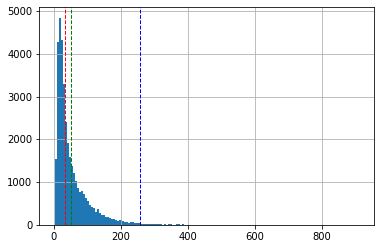

valeur du 99eme percentile = 257.0


In [ ]:
plt.figure()
df_effective_args['Longueur_texte'].hist(bins=150)
plt.axvline(df_effective_args['Longueur_texte'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_effective_args['Longueur_texte'].median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(df_effective_args['Longueur_texte'].quantile(.99), color='b', linestyle='dashed', linewidth=1)
plt.show()

print('valeur du 99eme percentile =', df_effective_args['Longueur_texte'].quantile(.99))

In [ ]:
MAX_LEN = 270

# Encodage BERT

In [ ]:
# sample_sequence = df_effective_args['discourse_type_SEP_discourse_text'].iloc[500]
# print(sample_sequence)


# token = tokenizer_BERT(sample_sequence, 
#                   max_length         = MAX_LEN, 
#                   truncation         = True, 
#                   padding            = 'max_length',
#                   add_special_tokens = True,
#                   return_tensors     = "np"
#                  )
    
# print('\ninput_ids:')
# print(token['input_ids'])
# print('\nattention_mask:')
# print(token['attention_mask'])
# print(token['attention_mask'].sum())
# print(len(tokenizer_BERT.tokenize(sample_sequence)))

In [ ]:
def bert_encode(texts, tokenizer = tokenizer_BERT):

    token = tokenizer(texts, 
                      max_length         = MAX_LEN, 
                      truncation         = True, 
                      padding            = "max_length",
                      add_special_tokens = True,
                      return_tensors     = "tf")
        
    input_ids = token['input_ids']
    attention_mask = token['attention_mask']
    
    return input_ids[0], attention_mask[0]

Let's have a look at what the tokenizer does with one sample:

The function bert_encode() returns two arrays: input_ids andattention_mask

https://huggingface.co/docs/transformers/main_classes/tokenizer

*   input_ids — List of token ids to be fed to a model.

*    attention_mask — List of indices specifying which tokens should be attended to by the model (when return_attention_mask=True or if “attention_mask” is in self.model_input_names).

# Creation modele

## Hyper-paramètres

In [ ]:
# Configuration
BATCH_SIZE = 8
DROPOUT = 0.1
LEARNING_RATE = 1e-4
MAX_LEN = MAX_LEN

In [ ]:
input_ids = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "input_ids")
attention_mask = tensorflow.keras.Input(shape = (MAX_LEN, ), dtype = tensorflow.int32, name = "attention_mask")

transformer_layer = (transformers.TFAutoModel.from_pretrained(MODEL_NAME))

sequence_output = transformer_layer([input_ids, attention_mask])['last_hidden_state']
clf_output = sequence_output[:, 0, :]
layer = tensorflow.keras.layers.Dropout(0.4)(clf_output)
layer = tensorflow.keras.layers.Dense(1152, activation="relu")(layer)
layer = tensorflow.keras.layers.Dropout(0.4)(layer)
layer = tensorflow.keras.layers.Dense(128, activation="relu")(layer)
layer = tensorflow.keras.layers.Dropout(DROPOUT)(layer)
out = tensorflow.keras.layers.Dense(3, activation='softmax')(layer)

model = tensorflow.keras.Model(inputs = [input_ids, attention_mask], 
              outputs = out)

model.compile(tensorflow.keras.optimizers.Adam(learning_rate = LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


ValueError: ignored

## Resumé du modèle

In [ ]:
model.summary()

In [ ]:
X = df_effective_args['discourse_type_SEP_discourse_text']
y = df_effective_args['discourse_effectiveness_number']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = list(y_train)
y_valid= list(y_valid)

In [ ]:
X_train = X_train.transform(bert_encode)
X_valid = X_valid.transform(bert_encode)
X_train_words_encoded, X_train_mask = zip(*X_train)
X_valid_words_encoded, X_valid_mask = zip(*X_valid)

Dataset Valid

In [ ]:
valid_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_words_encoded)))
            .batch(BATCH_SIZE)
)


valid_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_valid_mask)))
            .batch(BATCH_SIZE)
)

valid_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_valid))
            .batch(BATCH_SIZE)
)

data_valid_words_mask = tensorflow.data.Dataset.zip((valid_input_words_dataset, valid_input_mask_dataset))
data_valid = tensorflow.data.Dataset.zip((data_valid_words_mask, valid_output_dataset))
print(data_valid.element_spec)

Dataset train

In [ ]:
train_input_words_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_words_encoded)))
            .batch(BATCH_SIZE)
)


train_input_mask_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((list(X_train_mask)))
            .batch(BATCH_SIZE)
)

train_output_dataset = (
            tensorflow.data.Dataset
            .from_tensor_slices((y_train))
            .batch(BATCH_SIZE)
)

data_train_words_mask = tensorflow.data.Dataset.zip((train_input_words_dataset, train_input_mask_dataset))
data_train = tensorflow.data.Dataset.zip((data_train_words_mask, train_output_dataset))

print(data_train.element_spec)

## Entrainement

In [ ]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor='valid_loss',
    min_delta=0.03,
    patience=4,
    #mode='max',
    verbose=1)

history = model.fit(
    data_train, 
    epochs=50,
    #validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    #steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition]    
)

model.save('/content/drive/MyDrive/Colab_Notebooks/P8/models/bert.h5')

In [ ]:
plot_curves(history)